Homework No. 4
Due 10/15 (11:00 pm), 2024 (150 points)

Objectives
1.	Apply Kernel SVM and MLP classification algorithms to the fashion-MNIST dataset
2.	Use k-fold cross validation to identify the best way to rescale and preprocess the data
3.	Use k-fold cross validation to identify the parameters that optimize performance (generalization) for each method.
4.	Compare the accuracy and identify correlation between the outputs of the two methods
Problem
For this homework, you will apply the following classification methods to the fashion-MNIST classification data  
1.	Kernel Support Vector Machines
2.	Multilayer Perceptrons
•	Apply 4-fold cross-validation to the provided training data subset to train your classifiers and identify their optimal parameters. You need to justify your choice of the optimal parameters by displaying and explaining plots of the train/validate accuracy versus the parameter. In addition to the classifier’s parameters (e.g. regularization, kernel, No. of layers/nodes, learning rate, etc.), you should also consider the following 3 ways to preprocess and rescale the data: 
a)	No preprocessing 
b)	StandardScaler
c)	MinMaxScaler
•	After fixing the classifiers’ parameters, apply each method to the provided testing data subset to predict and analyze your results. Compare the accuracy obtained during training to those of the test data and comment on the results (overfitting, underfitting, etc.) 
•	Analyze the correlation between the output of the 2 classifiers by displaying the predict_proba of SVM vs. predict_proba of MLP (using test data). Using these scatter plots (one per class), identify (if available) the following 3 groups
•	G-1: Samples that are easy to classify correctly by the SVM, but hard to classify by MLP
•	G-2: Samples that are easy to classify correctly by the MLP, but hard to classify by SVM
•	G-3: Samples that are hard to classify correctly by both methods
For each group, display few samples (as images) and identify any common features among them.
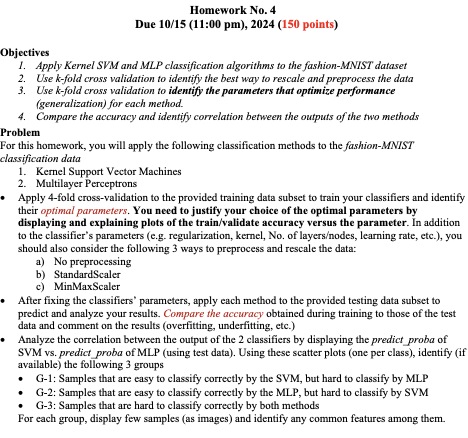

In [23]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score

In [24]:
X_train = pd.read_csv('~/Desktop/Machine_Learning/dataset/X_rain.csv')
X_test = pd.read_csv('~/Desktop/Machine_Learning/dataset/X_test.csv')
y_train = pd.read_csv('~/Desktop/Machine_Learning/dataset/y_train.csv').values.ravel()
y_test = pd.read_csv('~/Desktop/Machine_Learning/dataset/y_test.csv').values.ravel()

In [25]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9999, 784)
X_test shape: (4999, 784)
y_train shape: (9999,)
y_test shape: (4999,)


mini-Fashion-MNIST is a dataset composed of 10,000 samples for training and 5000 samples for testing.

Each of the two subsets contain small square 28×28 pixel grayscale images of items of 5 types of clothing. 

Features are pixel intensity (0-255).
The mapping of all 0-4 integers to class labels is: 
0: T-shirt/top 
1: Trouser 
2: Pullover 
3: Dress 
4: Coat 

The data is balanced: 2000 samples per class.


In [26]:
print(X_train.head())

   0  0.1  0.2  0.3  0.4  1  0.5  0.6  0.7  0.8  ...  119  114  130.1  76.1  \
0  0    0    0    0    0  0    0    0    0   22  ...    0    0      1     0   
1  0    0    0    0    0  0    0    0    0    0  ...    0    0      0     0   
2  0    0    0    0    0  0    0   11  142  200  ...  120  110    158    18   
3  0    0    0    0    0  0    0    0    0    0  ...   91   80     46     0   
4  0    0    0    0    0  0    0    0   58  121  ...   21   23     30    37   

   0.291  0.292  0.293  0.294  0.295  0.296  
0      0      0      0      0      0      0  
1      0      0      0      0      0      0  
2      0      3      0      0      0      0  
3      0      1      0      0      0      0  
4      0      0      1      0      0      0  

[5 rows x 784 columns]


In [27]:
print(X_test.head())

   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8   52  ...  187.5  173.1  148  \
0  0    0    0    0    0    0    0    0    0   74  ...    105     15    0   
1  0    0    0    0    0    0    0    0    0    0  ...     34     33   14   
2  0    0    0    0    0    0    0    0    0   18  ...     54     51   63   
3  0    0    0    0    0    0    0   26   64  134  ...     41     41   37   
4  0    0    0    0    0    0    2    3    0    0  ...    107    123   72   

   0.302  0.303  1.17  0.304  0.305  0.306  0.307  
0      0      0     0      0      0      0      0  
1      0      1     0      0      0      0      0  
2     34      0     1      0      0      0      0  
3     35     36    36      0      0      0      0  
4      0      3     0      0      0      0      0  

[5 rows x 784 columns]


In [28]:
print(y_train[:5])

[0 0 0 0 0]


In [29]:
print(y_test[:5])

[0 0 0 0 0]


In [30]:
import seaborn as sns

parameters:
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']


scales: 
    'Unscaled': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()

kf = KFold(n_splits=4, shuffle=True, random_state=42)

In [59]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Initialize the SVC model with specified parameters
svc = SVC(kernel='rbf', C=0.01, gamma=0.001)

# Lists to store training accuracies, validation accuracies, and times
train_accuracies = []
val_accuracies = []
times_taken = []

# Perform cross-validation manually
for train_index, val_index in kf.split(X_train):
    # Use .iloc to index by row number for DataFrames
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Start timer
    start_time = time.time()

    # Fit the model
    svc.fit(X_train_fold, y_train_fold)

    # End timer and calculate time taken
    time_taken = time.time() - start_time
    times_taken.append(time_taken)

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
    train_accuracies.append(train_accuracy)

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
    val_accuracies.append(val_accuracy)

# Calculate the average training accuracy, validation accuracy, and time taken
avg_train_accuracy = np.mean(train_accuracies)
avg_val_accuracy = np.mean(val_accuracies)
avg_time_taken = np.mean(times_taken)

# Print the results
print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Time Taken: {avg_time_taken:.4f} seconds")

Average Training Accuracy: 0.2039
Average Validation Accuracy: 0.1883
Average Time Taken: 32.9248 seconds


In [60]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Parameter grids for C and gamma
C_values = [0.1, 1, 10]
gamma_values = [0.1, 1, 10]

# List to store results for each combination of C and gamma
results = []

# Loop through different values of C and gamma
for C in C_values:
    for gamma in gamma_values:
        print(f"Testing unscaled SVM with Kernal RBF  with C={C}, gamma={gamma}")

        # Initialize the SVC model with the current C and gamma
        svc = SVC(kernel='rbf', C=C, gamma=gamma)

        # Lists to store training accuracies, validation accuracies, and times
        train_accuracies = []
        val_accuracies = []
        times_taken = []

        # Perform cross-validation manually
        for train_index, val_index in kf.split(X_train):
            # Use .iloc to index by row number for DataFrames
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Start timer
            start_time = time.time()

            # Fit the model
            svc.fit(X_train_fold, y_train_fold)

            # End timer and calculate time taken
            time_taken = time.time() - start_time
            times_taken.append(time_taken)

            # Calculate training accuracy
            train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
            train_accuracies.append(train_accuracy)

            # Calculate validation accuracy
            val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
            val_accuracies.append(val_accuracy)

        # Calculate the average training accuracy, validation accuracy, and time taken
        avg_train_accuracy = np.mean(train_accuracies)
        avg_val_accuracy = np.mean(val_accuracies)
        avg_time_taken = np.mean(times_taken)

        # Print the results for this combination
        print(f"C={C}, gamma={gamma} -> Average Training Accuracy: {avg_train_accuracy:.4f}, "
              f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
              f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

        # Store the results for this combination in the results list
        results.append({
            'C': C,
            'gamma': gamma,
            'avg_train_accuracy': avg_train_accuracy,
            'avg_val_accuracy': avg_val_accuracy,
            'avg_time_taken': avg_time_taken
        })

# You can convert the results to a DataFrame for easy analysis if needed
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)

Testing SVM with C=0.1, gamma=0.1
C=0.1, gamma=0.1 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 32.8184 seconds

Testing SVM with C=0.1, gamma=1
C=0.1, gamma=1 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 36.5434 seconds

Testing SVM with C=0.1, gamma=10
C=0.1, gamma=10 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 33.0848 seconds

Testing SVM with C=1, gamma=0.1
C=1, gamma=0.1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.1883, Average Time Taken: 33.1585 seconds

Testing SVM with C=1, gamma=1
C=1, gamma=1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.1883, Average Time Taken: 33.2269 seconds

Testing SVM with C=1, gamma=10
C=1, gamma=10 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.1883, Average Time Taken: 33.3337 seconds

Testing SVM with C=10, gamma=0.1
C=10, gamma=0

In [6]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Parameter grids for C and gamma
C_values = [.01, 0.1, 1, 10]
gamma_values = [.01, 0.1, 1, 10]

# List to store results for each combination of C and gamma
results = []

# Loop through different values of C and gamma
for C in C_values:
    for gamma in gamma_values:
        print(f"Testing unscaled SVM with kernal poly with C={C}, gamma={gamma}")

        # Initialize the SVC model with the current C and gamma
        svc = SVC(kernel='poly', C=C, gamma=gamma)

        # Lists to store training accuracies, validation accuracies, and times
        train_accuracies = []
        val_accuracies = []
        times_taken = []

        # Perform cross-validation manually
        for train_index, val_index in kf.split(X_train):
            # Use .iloc to index by row number for DataFrames
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Start timer
            start_time = time.time()

            # Fit the model
            svc.fit(X_train_fold, y_train_fold)

            # End timer and calculate time taken
            time_taken = time.time() - start_time
            times_taken.append(time_taken)

            # Calculate training accuracy
            train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
            train_accuracies.append(train_accuracy)

            # Calculate validation accuracy
            val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
            val_accuracies.append(val_accuracy)

        # Calculate the average training accuracy, validation accuracy, and time taken
        avg_train_accuracy = np.mean(train_accuracies)
        avg_val_accuracy = np.mean(val_accuracies)
        avg_time_taken = np.mean(times_taken)

        # Print the results for this combination
        print(f"C={C}, gamma={gamma} -> Average Training Accuracy: {avg_train_accuracy:.4f}, "
              f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
              f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

        # Store the results for this combination in the results list
        results.append({
            'C': C,
            'gamma': gamma,
            'avg_train_accuracy': avg_train_accuracy,
            'avg_val_accuracy': avg_val_accuracy,
            'avg_time_taken': avg_time_taken
        })

# You can convert the results to a DataFrame for easy analysis if needed
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)

Testing poly SVM with C=0.01, gamma=0.01
C=0.01, gamma=0.01 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8721, Average Time Taken: 3.7652 seconds

Testing poly SVM with C=0.01, gamma=0.1
C=0.01, gamma=0.1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8722, Average Time Taken: 3.7304 seconds

Testing poly SVM with C=0.01, gamma=1
C=0.01, gamma=1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8722, Average Time Taken: 3.6876 seconds

Testing poly SVM with C=0.01, gamma=10
C=0.01, gamma=10 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8721, Average Time Taken: 3.7806 seconds

Testing poly SVM with C=0.1, gamma=0.01
C=0.1, gamma=0.01 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8721, Average Time Taken: 3.8005 seconds

Testing poly SVM with C=0.1, gamma=0.1
C=0.1, gamma=0.1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8722, Average Time Taken: 3.7622 s

In [8]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Parameter grids for C and gamma
C_values = [0.01, 0.1, 1, 10]
gamma_values = [0.01, 0.1, 1, 10]

# Function to scale only X_train
def scale_data(X_train, scaler):
    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled

# List of scalers: MinMaxScaler and StandardScaler
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

# Loop through the scalers (MinMaxScaler and StandardScaler)
for scaler_name, scaler in scalers.items():
    print(f"\nRunning with {scaler_name}...\n")
    
    # Scale X_train only (no need to scale X_test for cross-validation)
    X_train_scaled = scale_data(X_train, scaler)

    # List to store results for each combination of C and gamma
    results = []

    # Test with polynomial kernel (since you observed performance improvements here)
    for C in C_values:
        for gamma in gamma_values:
            print(f"Testing SVM with poly kernal with C={C}, gamma={gamma}, using {scaler_name}")

            # Initialize the SVC model with the current C and gamma for polynomial kernel
            svc = SVC(kernel='poly', C=C, gamma=gamma)

            # Lists to store training accuracies, validation accuracies, and times
            train_accuracies = []
            val_accuracies = []
            times_taken = []

            # Perform cross-validation manually
            for train_index, val_index in kf.split(X_train_scaled):
                # Split the scaled training data
                X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                # Start timer
                start_time = time.time()

                # Fit the model
                svc.fit(X_train_fold, y_train_fold)

                # End timer and calculate time taken
                time_taken = time.time() - start_time
                times_taken.append(time_taken)

                # Calculate training accuracy
                train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
                train_accuracies.append(train_accuracy)

                # Calculate validation accuracy
                val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
                val_accuracies.append(val_accuracy)

            # Calculate the average training accuracy, validation accuracy, and time taken
            avg_train_accuracy = np.mean(train_accuracies)
            avg_val_accuracy = np.mean(val_accuracies)
            avg_time_taken = np.mean(times_taken)

            # Print the results for this combination
            print(f"C={C}, gamma={gamma} -> Average Training Accuracy: {avg_train_accuracy:.4f}, "
                  f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
                  f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

            # Store the results for this combination in the results list
            results.append({
                'scaler': scaler_name,
                'C': C,
                'gamma': gamma,
                'avg_train_accuracy': avg_train_accuracy,
                'avg_val_accuracy': avg_val_accuracy,
                'avg_time_taken': avg_time_taken
            })

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(results)

    # Print the results DataFrame
    print(f"\nResults for {scaler_name}:\n")
    print(results_df)


Running with MinMaxScaler...

Testing poly SVM with C=0.01, gamma=0.01, using MinMaxScaler
C=0.01, gamma=0.01 -> Average Training Accuracy: 0.7969, Average Validation Accuracy: 0.7913, Average Time Taken: 13.6423 seconds

Testing poly SVM with C=0.01, gamma=0.1, using MinMaxScaler
C=0.01, gamma=0.1 -> Average Training Accuracy: 0.9842, Average Validation Accuracy: 0.8801, Average Time Taken: 4.6874 seconds

Testing poly SVM with C=0.01, gamma=1, using MinMaxScaler
C=0.01, gamma=1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8723, Average Time Taken: 3.6589 seconds

Testing poly SVM with C=0.01, gamma=10, using MinMaxScaler
C=0.01, gamma=10 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8723, Average Time Taken: 3.6730 seconds

Testing poly SVM with C=0.1, gamma=0.01, using MinMaxScaler
C=0.1, gamma=0.01 -> Average Training Accuracy: 0.8636, Average Validation Accuracy: 0.8466, Average Time Taken: 24.7259 seconds

Testing poly SVM with C=0.

In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Parameter grids for C and gamma
C_values = [0.01, 0.1, 1]
gamma_values = [0.01, 0.1, 1]

# Function to scale only X_train
def scale_data(X_train, scaler):
    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled

# List of scalers: MinMaxScaler and StandardScaler
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

# Loop through the scalers (MinMaxScaler and StandardScaler)
for scaler_name, scaler in scalers.items():
    print(f"\nRunning with {scaler_name}...\n")
    
    # Scale X_train only (no need to scale X_test for cross-validation)
    X_train_scaled = scale_data(X_train, scaler)

    # List to store results for each combination of C and gamma
    results = []

    # Test with polynomial kernel (since you observed performance improvements here)
    for C in C_values:
        for gamma in gamma_values:
            print(f"Testing SVM with rbf kernal with C={C}, gamma={gamma}, using {scaler_name}")

            # Initialize the SVC model with the current C and gamma for polynomial kernel
            svc = SVC(kernel='rbf', C=C, gamma=gamma)

            # Lists to store training accuracies, validation accuracies, and times
            train_accuracies = []
            val_accuracies = []
            times_taken = []

            # Perform cross-validation manually
            for train_index, val_index in kf.split(X_train_scaled):
                # Split the scaled training data
                X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                # Start timer
                start_time = time.time()

                # Fit the model
                svc.fit(X_train_fold, y_train_fold)

                # End timer and calculate time taken
                time_taken = time.time() - start_time
                times_taken.append(time_taken)

                # Calculate training accuracy
                train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
                train_accuracies.append(train_accuracy)

                # Calculate validation accuracy
                val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
                val_accuracies.append(val_accuracy)

            # Calculate the average training accuracy, validation accuracy, and time taken
            avg_train_accuracy = np.mean(train_accuracies)
            avg_val_accuracy = np.mean(val_accuracies)
            avg_time_taken = np.mean(times_taken)

            # Print the results for this combination
            print(f"C={C}, gamma={gamma} -> Average Training Accuracy: {avg_train_accuracy:.4f}, "
                  f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
                  f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

            # Store the results for this combination in the results list
            results.append({
                'scaler': scaler_name,
                'C': C,
                'gamma': gamma,
                'avg_train_accuracy': avg_train_accuracy,
                'avg_val_accuracy': avg_val_accuracy,
                'avg_time_taken': avg_time_taken
            })

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(results)

    # Print the results DataFrame
    print(f"\nResults for {scaler_name}:\n")
    print(results_df)


Running with MinMaxScaler...

Testing SVM with rbf kernal with C=0.01, gamma=0.01, using MinMaxScaler
C=0.01, gamma=0.01 -> Average Training Accuracy: 0.7854, Average Validation Accuracy: 0.7836, Average Time Taken: 23.0081 seconds

Testing SVM with rbf kernal with C=0.01, gamma=0.1, using MinMaxScaler
C=0.01, gamma=0.1 -> Average Training Accuracy: 0.2925, Average Validation Accuracy: 0.2772, Average Time Taken: 49.7230 seconds

Testing SVM with rbf kernal with C=0.01, gamma=1, using MinMaxScaler
C=0.01, gamma=1 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 33.5535 seconds

Testing SVM with rbf kernal with C=0.01, gamma=10, using MinMaxScaler
C=0.01, gamma=10 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 34.3083 seconds

Testing SVM with rbf kernal with C=0.1, gamma=0.01, using MinMaxScaler
C=0.1, gamma=0.01 -> Average Training Accuracy: 0.8607, Average Validation Accuracy: 0.8546, Avera

In [13]:
rbf_unscaled_df = pd.DataFrame({
    'C': [0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0],
    'gamma': [0.1, 1.0, 10.0, 0.1, 1.0, 10.0, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.203887, 0.203887, 0.203887, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000],
    'avg_val_accuracy': [0.188319, 0.188319, 0.188319, 0.188319, 0.188319, 0.188319, 0.188319, 0.188319, 0.188319],
    'avg_time_taken': [32.81, 36.54, 33.08, 33.16, 33.22, 33.33, 33.36, 33.34, 33.37]
})

# Unscaled results for Polynomial (example)
poly_unscaled_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 0.01, 0.1, 1.0, 0.01, 0.1, 1.0, 0.01, 0.1, 1.0],
    'avg_train_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'avg_val_accuracy': [0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721],
    'avg_time_taken': [3.78, 3.73, 3.68, 3.80, 3.76, 3.81, 3.78, 3.79, 3.78, 3.79, 3.80, 3.79]
})

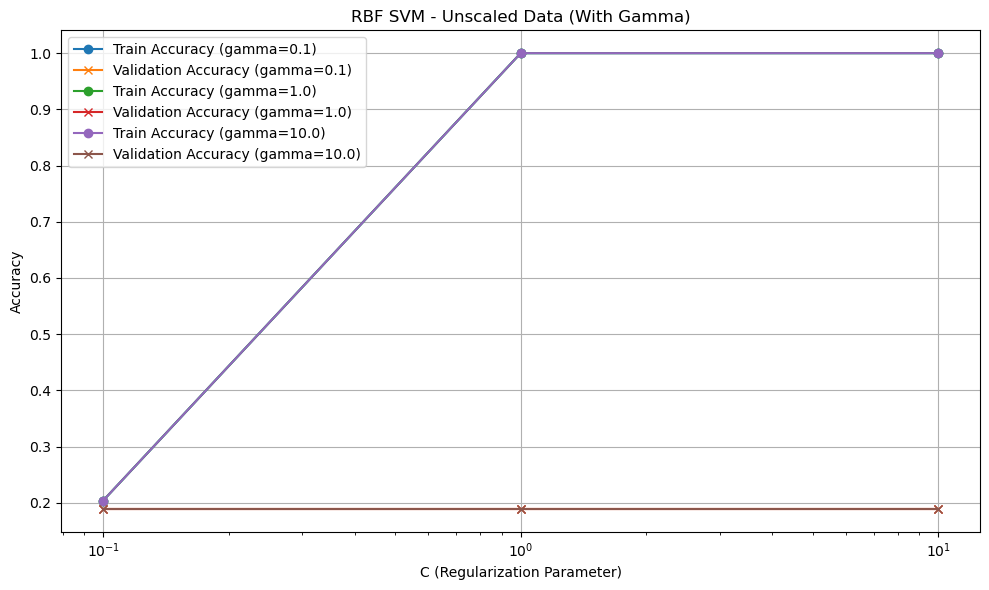

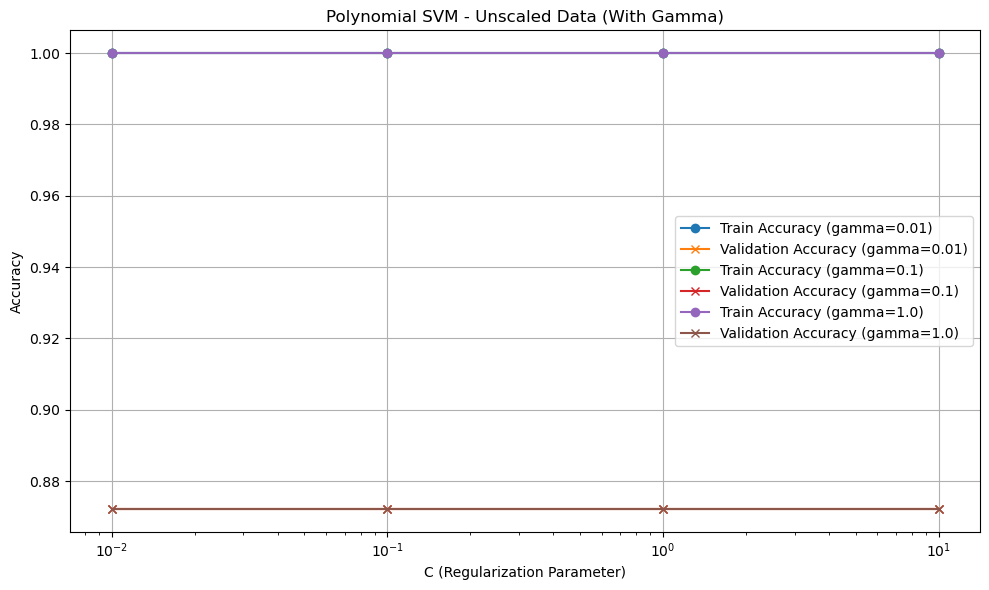

In [25]:
def plot_comparison_with_gamma(df, title):
    plt.figure(figsize=(10, 6))
    
    # Group by gamma and plot separately for each gamma value
    unique_gamma_values = df['gamma'].unique()
    
    for gamma in unique_gamma_values:
        df_gamma = df[df['gamma'] == gamma]
        plt.plot(df_gamma['C'], df_gamma['avg_train_accuracy'], label=f'Train Accuracy (gamma={gamma})', marker='o')
        plt.plot(df_gamma['C'], df_gamma['avg_val_accuracy'], label=f'Validation Accuracy (gamma={gamma})', marker='x')
    
    plt.xscale('log')  # Use log scale for C
    plt.xlabel('C (Regularization Parameter)')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.grid(True)
    
    # Add legend
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot RBF SVM - Unscaled Data with Gamma
plot_comparison_with_gamma(rbf_unscaled_df, "RBF SVM - Unscaled Data (With Gamma)")

# Plot Polynomial SVM - Unscaled Data with Gamma
plot_comparison_with_gamma(poly_unscaled_df, "Polynomial SVM - Unscaled Data (With Gamma)")

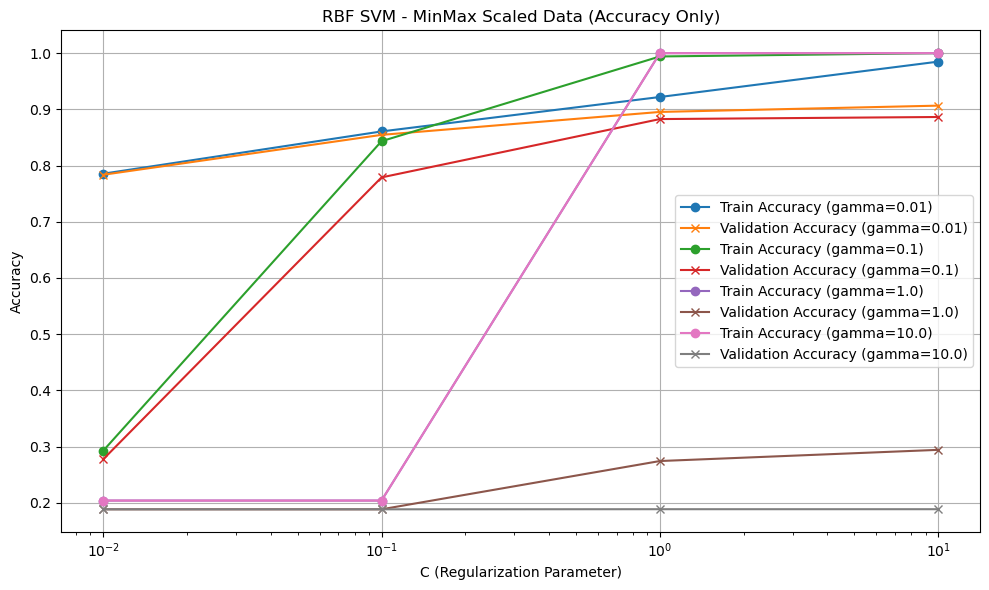

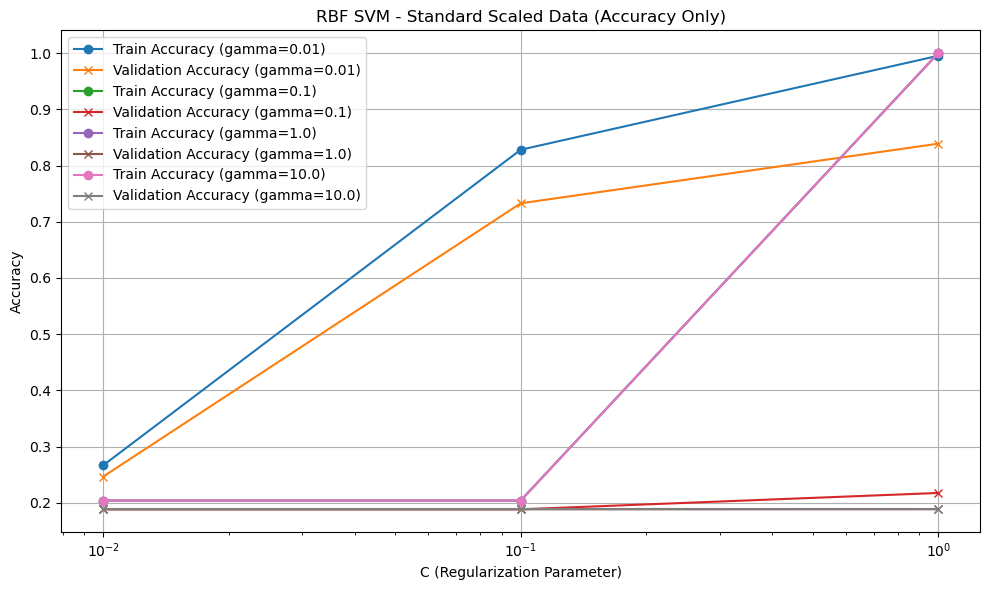

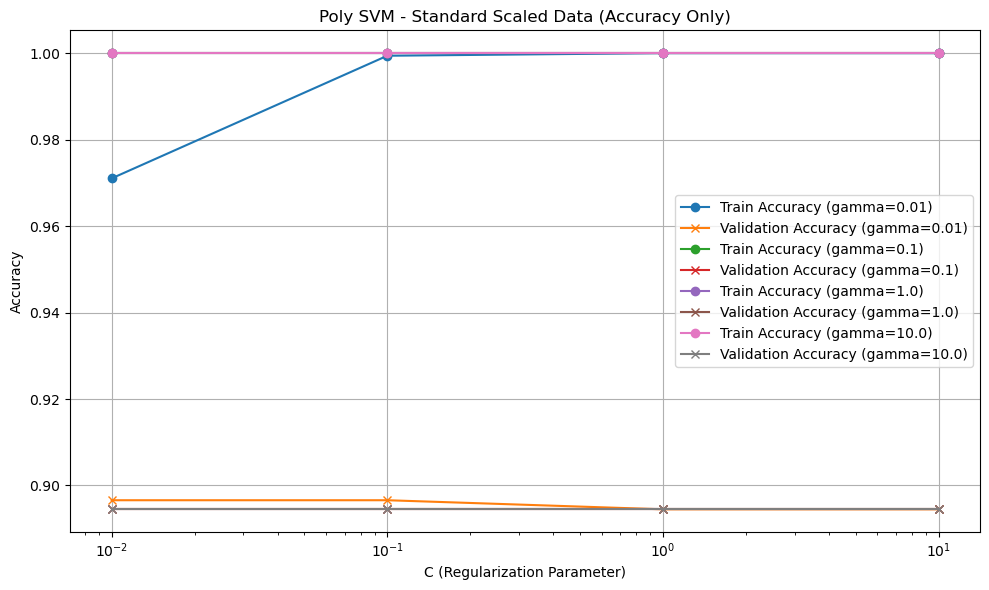

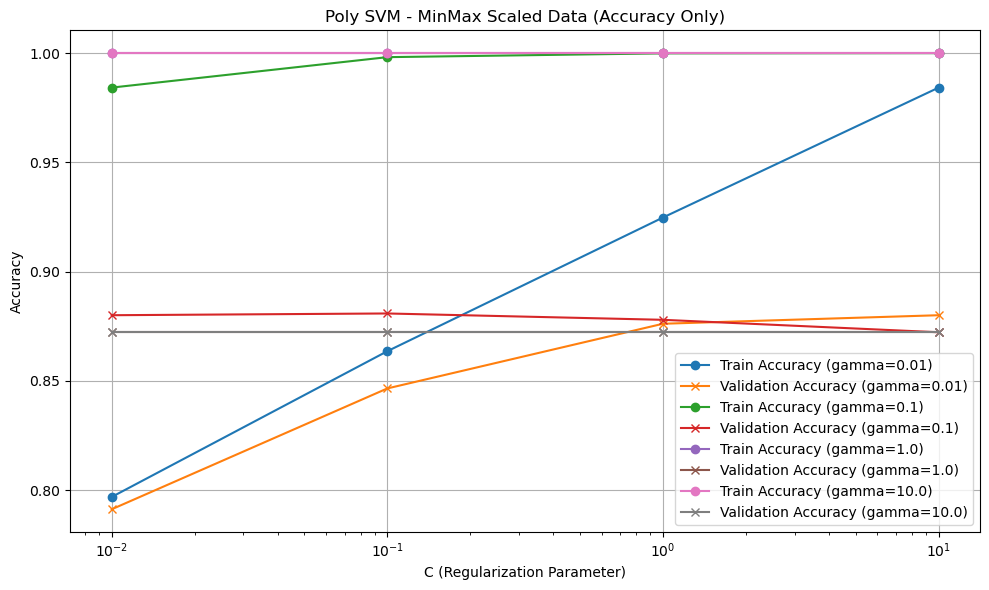

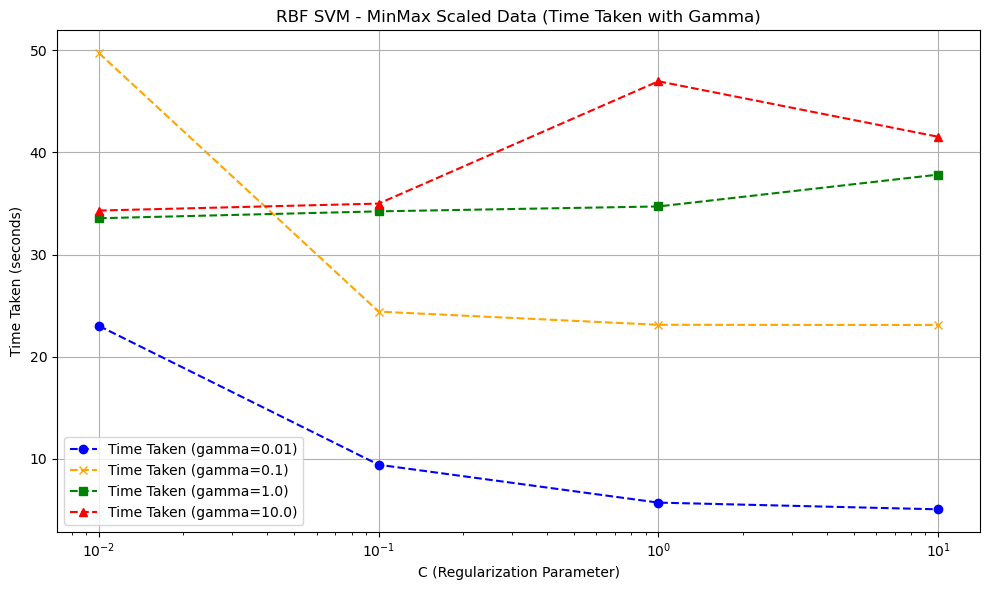

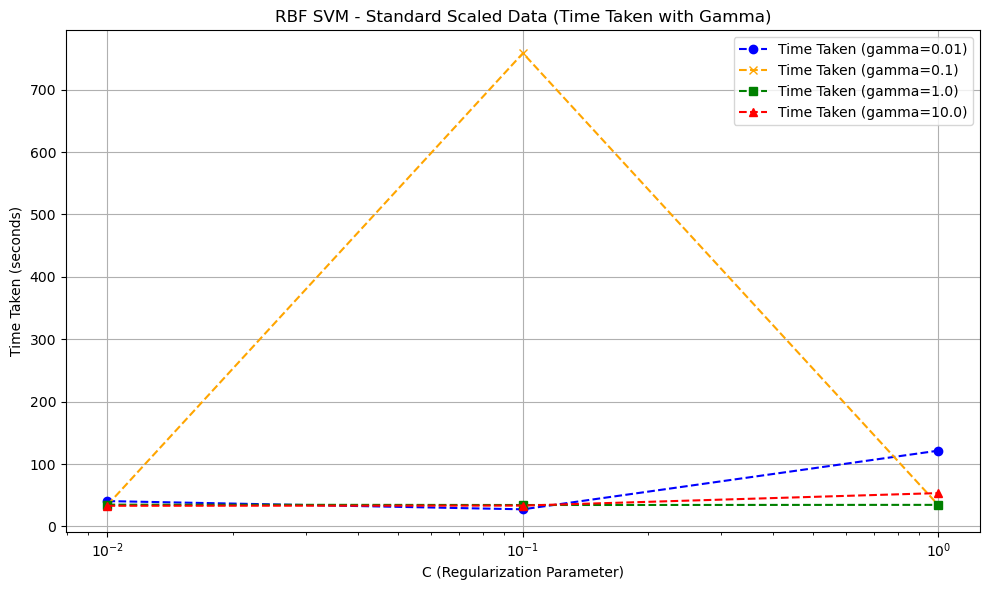

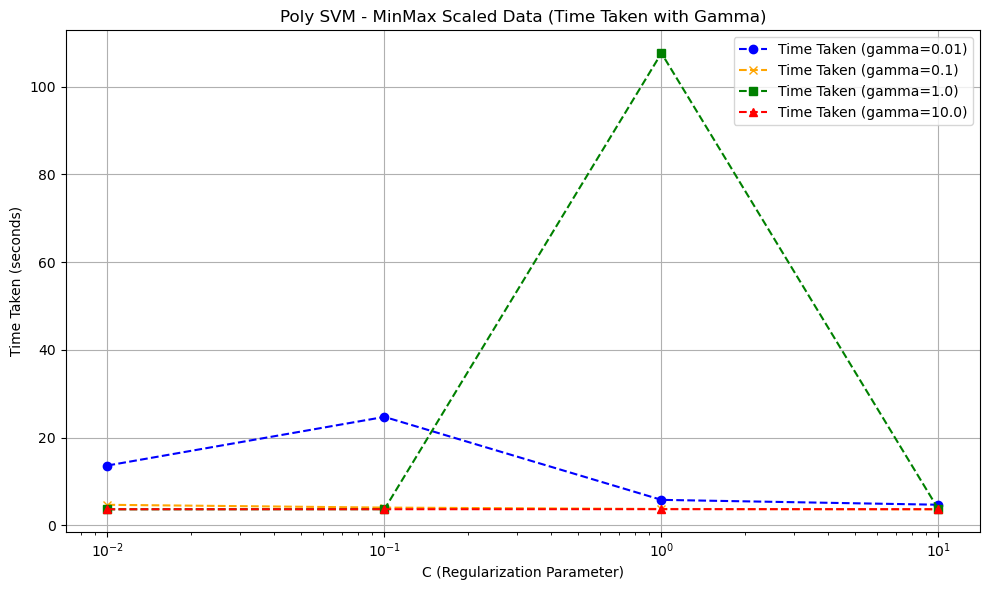

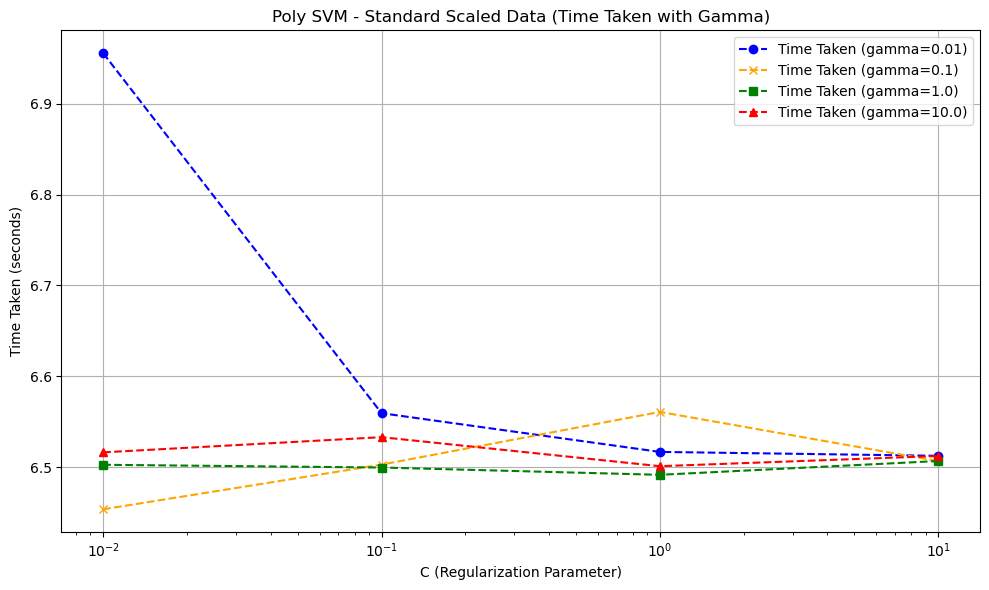

In [32]:
rbf_minmax_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.785445, 0.292463, 0.203887, 0.203887, 0.860686, 0.843284, 0.203887, 0.203887, 0.921959, 0.994099, 1.000000, 1.000000, 0.984899, 1.000000, 1.000000, 1.000000],
    'avg_val_accuracy': [0.783578, 0.277228, 0.188319, 0.188319, 0.854585, 0.778878, 0.188319, 0.188319, 0.895389, 0.882688, 0.274227, 0.188519, 0.906590, 0.886388, 0.294129, 0.188519],
    'avg_time_taken': [23.008085, 49.722987, 33.553515, 34.308282, 9.411522, 24.406856, 34.227162, 34.988520, 5.702963, 23.118198, 34.708789, 46.967912, 5.047071, 23.097557, 37.824980, 41.536860]
})

rbf_standard_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0],
    'gamma': [0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.2665, 0.2039, 0.2039, 0.2039, 0.8281, 0.2039, 0.2039, 0.2039, 0.9953, 1.0000, 1.0000, 1.0000],
    'avg_val_accuracy': [0.2465, 0.1883, 0.1883, 0.1883, 0.7328, 0.1883, 0.1883, 0.1883, 0.8389, 0.2174, 0.1884, 0.1883],
    'avg_time_taken': [40.5582, 34.3457, 34.8777, 33.0580, 27.3886, 758.6696, 34.2952, 33.3387, 121.4667, 33.9954, 34.5252, 53.3935]
})

# MinMaxScaler results
poly_minmax_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.796913, 0.984232, 1.000000, 1.000000, 0.863620, 0.998166, 1.000000, 1.000000, 0.924792, 0.999900, 1.000000, 1.000000, 0.984232, 1.000000, 1.000000, 1.000000],
    'avg_val_accuracy': [0.791280, 0.880087, 0.872287, 0.872287, 0.846584, 0.880887, 0.872287, 0.872287, 0.876186, 0.877988, 0.872287, 0.872287, 0.880087, 0.872287, 0.872287, 0.872287],
    'avg_time_taken': [13.642346, 4.687351, 3.658906, 3.672971, 24.725939, 4.049554, 3.690097, 3.679133, 5.812937, 3.738050, 107.652860, 3.691382, 4.702492, 3.663396, 3.670600, 3.682496]
})

# StandardScaler results
poly_standard_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.97103, 1.00000, 1.00000, 1.00000, 0.99940, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000],
    'avg_val_accuracy': [0.896590, 0.894489, 0.894489, 0.894489, 0.896590, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489],
    'avg_time_taken': [6.955760, 6.453611, 6.502625, 6.516308, 6.559425, 6.502808, 6.499614, 6.533026, 6.516806, 6.560819, 6.491585, 6.501079, 6.512503, 6.506678, 6.506780, 6.512290]
})

def plot_comparison_with_gamma(df, title):
    plt.figure(figsize=(10, 6))

    # Group by gamma and plot separately for each gamma value (for accuracy)
    unique_gamma_values = df['gamma'].unique()
    
    for gamma in unique_gamma_values:
        df_gamma = df[df['gamma'] == gamma]
        plt.plot(df_gamma['C'], df_gamma['avg_train_accuracy'], label=f'Train Accuracy (gamma={gamma})', marker='o')
        plt.plot(df_gamma['C'], df_gamma['avg_val_accuracy'], label=f'Validation Accuracy (gamma={gamma})', marker='x')
    
    plt.xscale('log')  # Use log scale for C
    plt.xlabel('C (Regularization Parameter)')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.grid(True)

    # Add legend
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

# Plotting only accuracy for MinMaxScaler
plot_comparison_with_gamma(rbf_minmax_df, "RBF SVM - MinMax Scaled Data (Accuracy Only)")

# Plotting only accuracy for StandardScaler
plot_comparison_with_gamma(rbf_standard_df, "RBF SVM - Standard Scaled Data (Accuracy Only)")

plot_comparison_with_gamma(poly_standard_df, "Poly SVM - Standard Scaled Data (Accuracy Only)")

plot_comparison_with_gamma(poly_minmax_df, "Poly SVM - MinMax Scaled Data (Accuracy Only)")


# Separate plotting function for time only
def plot_time_with_gamma(df, title):
    plt.figure(figsize=(10, 6))

    # Group by gamma and plot separately for each gamma value (for time)
    unique_gamma_values = df['gamma'].unique()
    markers = ['o', 'x', 's', '^']  # Different markers for gamma values
    colors = ['blue', 'orange', 'green', 'red']  # Different colors for gamma values

    for i, gamma in enumerate(unique_gamma_values):
        df_gamma = df[df['gamma'] == gamma]
        plt.plot(df_gamma['C'], df_gamma['avg_time_taken'], label=f'Time Taken (gamma={gamma})', 
                 color=colors[i], linestyle='--', marker=markers[i])
    
    plt.xscale('log')  # Use log scale for C
    plt.xlabel('C (Regularization Parameter)')
    plt.ylabel('Time Taken (seconds)')
    plt.title(title)
    plt.grid(True)

    # Add legend
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()
plot_time_with_gamma(rbf_minmax_df, "RBF SVM - MinMax Scaled Data (Time Taken with Gamma)")

# Plotting time for StandardScaler with gamma differentiation
plot_time_with_gamma(rbf_standard_df, "RBF SVM - Standard Scaled Data (Time Taken with Gamma)")

plot_time_with_gamma(poly_minmax_df, "Poly SVM - MinMax Scaled Data (Time Taken with Gamma)")

# Plotting time for StandardScaler with gamma differentiation
plot_time_with_gamma(poly_standard_df, "Poly SVM - Standard Scaled Data (Time Taken with Gamma)")

MLP

In [9]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Define parameter grid for MLP
hidden_layer_sizes_values = [(10,), (10, 10), (30,), (30, 30)]
alpha_values = [0.01, 1, 10]
solvers = ['adam', 'lbfgs']

# List of scalers: Unscaled, MinMaxScaler, and StandardScaler
scalers = {
    'Unscaled': None,
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

# Function to scale only X_train and convert to a NumPy array
def scale_data(X_train, scaler):
    if scaler is None:
        return X_train.values  # No scaling (unscaled data) and ensure it's a NumPy array
    else:
        X_train_scaled = scaler.fit_transform(X_train)
        return X_train_scaled  # Already a NumPy array after scaling

# Loop through the scalers (Unscaled, MinMaxScaler, and StandardScaler)
for scaler_name, scaler in scalers.items():
    print(f"\nRunning with {scaler_name}...\n")
    
    # Scale X_train only (no need to scale X_test for cross-validation)
    X_train_scaled = scale_data(X_train, scaler)

    # List to store results for each combination of parameters
    results = []

    # Loop through hidden_layer_sizes, alpha, and solver
    for hidden_layer_sizes in hidden_layer_sizes_values:
        for alpha in alpha_values:
            for solver in solvers:
                print(f"Testing MLP with hidden_layer_sizes={hidden_layer_sizes}, alpha={alpha}, solver={solver}, using {scaler_name}")

                # Initialize the MLPClassifier model with the current parameters
                mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, solver=solver, max_iter=2000, random_state=42)

                # Lists to store training accuracies, validation accuracies, and times
                train_accuracies = []
                val_accuracies = []
                times_taken = []

                # Perform cross-validation manually
                for train_index, val_index in kf.split(X_train_scaled):
                    # Split the scaled training data
                    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                    # Start timer
                    start_time = time.time()

                    # Fit the model
                    mlp.fit(X_train_fold, y_train_fold)

                    # End timer and calculate time taken
                    time_taken = time.time() - start_time
                    times_taken.append(time_taken)

                    # Calculate training accuracy
                    train_accuracy = accuracy_score(y_train_fold, mlp.predict(X_train_fold))
                    train_accuracies.append(train_accuracy)

                    # Calculate validation accuracy
                    val_accuracy = accuracy_score(y_val_fold, mlp.predict(X_val_fold))
                    val_accuracies.append(val_accuracy)

                # Calculate the average training accuracy, validation accuracy, and time taken
                avg_train_accuracy = np.mean(train_accuracies)
                avg_val_accuracy = np.mean(val_accuracies)
                avg_time_taken = np.mean(times_taken)

                # Print the results for this combination
                print(f"hidden_layer_sizes={hidden_layer_sizes}, alpha={alpha}, solver={solver} -> "
                      f"Average Training Accuracy: {avg_train_accuracy:.4f}, "
                      f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
                      f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

                # Store the results for this combination in the results list
                results.append({
                    'scaler': scaler_name,
                    'hidden_layer_sizes': hidden_layer_sizes,
                    'alpha': alpha,
                    'solver': solver,
                    'avg_train_accuracy': avg_train_accuracy,
                    'avg_val_accuracy': avg_val_accuracy,
                    'avg_time_taken': avg_time_taken
                })

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(results)

    # Print the results DataFrame
    print(f"\nResults for {scaler_name}:\n")
    print(results_df)


Running with Unscaled...

Testing MLP with hidden_layer_sizes=(10,), alpha=0.01, solver=adam, using Unscaled
hidden_layer_sizes=(10,), alpha=0.01, solver=adam -> Average Training Accuracy: 0.7222, Average Validation Accuracy: 0.6946, Average Time Taken: 8.0709 seconds

Testing MLP with hidden_layer_sizes=(10,), alpha=0.01, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


hidden_layer_sizes=(10,), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 0.6851, Average Validation Accuracy: 0.6733, Average Time Taken: 23.7368 seconds

Testing MLP with hidden_layer_sizes=(10,), alpha=1, solver=adam, using Unscaled
hidden_layer_sizes=(10,), alpha=1, solver=adam -> Average Training Accuracy: 0.8590, Average Validation Accuracy: 0.8113, Average Time Taken: 6.8330 seconds

Testing MLP with hidden_layer_sizes=(10,), alpha=1, solver=lbfgs, using Unscaled
hidden_layer_sizes=(10,), alpha=1, solver=lbfgs -> Average Training Accuracy: 0.5556, Average Validation Accuracy: 0.5505, Average Time Taken: 8.7928 seconds

Testing MLP with hidden_layer_sizes=(10,), alpha=10, solver=adam, using Unscaled
hidden_layer_sizes=(10,), alpha=10, solver=adam -> Average Training Accuracy: 0.8827, Average Validation Accuracy: 0.8423, Average Time Taken: 4.9991 seconds

Testing MLP with hidden_layer_sizes=(10,), alpha=10, solver=lbfgs, using Unscaled
hidden_layer_sizes=(10,), alpha=10, s

/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10, 10), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 0.8453, Average Validation Accuracy: 0.8239, Average Time Taken: 35.3869 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=1, solver=adam, using Unscaled
hidden_layer_sizes=(10, 10), alpha=1, solver=adam -> Average Training Accuracy: 0.9063, Average Validation Accuracy: 0.8451, Average Time Taken: 7.4072 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=1, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10, 10), alpha=1, solver=lbfgs -> Average Training Accuracy: 0.8578, Average Validation Accuracy: 0.8301, Average Time Taken: 40.5300 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=10, solver=adam, using Unscaled
hidden_layer_sizes=(10, 10), alpha=10, solver=adam -> Average Training Accuracy: 0.9078, Average Validation Accuracy: 0.8617, Average Time Taken: 6.7104 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=10, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10, 10), alpha=10, solver=lbfgs -> Average Training Accuracy: 0.8985, Average Validation Accuracy: 0.8280, Average Time Taken: 38.3988 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=0.01, solver=adam, using Unscaled
hidden_layer_sizes=(30,), alpha=0.01, solver=adam -> Average Training Accuracy: 0.8944, Average Validation Accuracy: 0.8414, Average Time Taken: 6.5921 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=0.01, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30,), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 0.9380, Average Validation Accuracy: 0.8531, Average Time Taken: 59.3720 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=1, solver=adam, using Unscaled
hidden_layer_sizes=(30,), alpha=1, solver=adam -> Average Training Accuracy: 0.8867, Average Validation Accuracy: 0.8382, Average Time Taken: 6.3480 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=1, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30,), alpha=1, solver=lbfgs -> Average Training Accuracy: 0.9003, Average Validation Accuracy: 0.8040, Average Time Taken: 45.5179 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=10, solver=adam, using Unscaled
hidden_layer_sizes=(30,), alpha=10, solver=adam -> Average Training Accuracy: 0.9229, Average Validation Accuracy: 0.8692, Average Time Taken: 10.9486 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=10, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30,), alpha=10, solver=lbfgs -> Average Training Accuracy: 0.9565, Average Validation Accuracy: 0.8430, Average Time Taken: 203.6559 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=0.01, solver=adam, using Unscaled
hidden_layer_sizes=(30, 30), alpha=0.01, solver=adam -> Average Training Accuracy: 0.9270, Average Validation Accuracy: 0.8502, Average Time Taken: 6.3386 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=0.01, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30, 30), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 0.9214, Average Validation Accuracy: 0.8726, Average Time Taken: 66.4018 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=1, solver=adam, using Unscaled
hidden_layer_sizes=(30, 30), alpha=1, solver=adam -> Average Training Accuracy: 0.9399, Average Validation Accuracy: 0.8596, Average Time Taken: 7.0398 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=1, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30, 30), alpha=1, solver=lbfgs -> Average Training Accuracy: 0.9222, Average Validation Accuracy: 0.8773, Average Time Taken: 67.3112 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=10, solver=adam, using Unscaled
hidden_layer_sizes=(30, 30), alpha=10, solver=adam -> Average Training Accuracy: 0.9282, Average Validation Accuracy: 0.8742, Average Time Taken: 12.4075 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=10, solver=lbfgs, using Unscaled


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30, 30), alpha=10, solver=lbfgs -> Average Training Accuracy: 0.9332, Average Validation Accuracy: 0.8757, Average Time Taken: 68.8517 seconds


Results for Unscaled:

      scaler hidden_layer_sizes  alpha solver  avg_train_accuracy  \
0   Unscaled              (10,)   0.01   adam            0.722245   
1   Unscaled              (10,)   0.01  lbfgs            0.685103   
2   Unscaled              (10,)   1.00   adam            0.858986   
3   Unscaled              (10,)   1.00  lbfgs            0.555594   
4   Unscaled              (10,)  10.00   adam            0.882655   
5   Unscaled              (10,)  10.00  lbfgs            0.644864   
6   Unscaled           (10, 10)   0.01   adam            0.915691   
7   Unscaled           (10, 10)   0.01  lbfgs            0.845284   
8   Unscaled           (10, 10)   1.00   adam            0.906290   
9   Unscaled           (10, 10)   1.00  lbfgs            0.857819   
10  Unscaled           (10, 10)  10.00   adam        

/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10,), alpha=1, solver=lbfgs -> Average Training Accuracy: 0.9965, Average Validation Accuracy: 0.8351, Average Time Taken: 33.4369 seconds

Testing MLP with hidden_layer_sizes=(10,), alpha=10, solver=adam, using MinMaxScaler
hidden_layer_sizes=(10,), alpha=10, solver=adam -> Average Training Accuracy: 0.8588, Average Validation Accuracy: 0.8521, Average Time Taken: 2.8187 seconds

Testing MLP with hidden_layer_sizes=(10,), alpha=10, solver=lbfgs, using MinMaxScaler


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10,), alpha=10, solver=lbfgs -> Average Training Accuracy: 0.9736, Average Validation Accuracy: 0.8804, Average Time Taken: 38.3342 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=0.01, solver=adam, using MinMaxScaler
hidden_layer_sizes=(10, 10), alpha=0.01, solver=adam -> Average Training Accuracy: 0.9732, Average Validation Accuracy: 0.8714, Average Time Taken: 18.2769 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=0.01, solver=lbfgs, using MinMaxScaler


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


hidden_layer_sizes=(10, 10), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 0.9947, Average Validation Accuracy: 0.8430, Average Time Taken: 38.2450 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=1, solver=adam, using MinMaxScaler
hidden_layer_sizes=(10, 10), alpha=1, solver=adam -> Average Training Accuracy: 0.9170, Average Validation Accuracy: 0.8813, Average Time Taken: 8.1978 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=1, solver=lbfgs, using MinMaxScaler


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10, 10), alpha=1, solver=lbfgs -> Average Training Accuracy: 0.9964, Average Validation Accuracy: 0.8400, Average Time Taken: 46.5532 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=10, solver=adam, using MinMaxScaler
hidden_layer_sizes=(10, 10), alpha=10, solver=adam -> Average Training Accuracy: 0.8581, Average Validation Accuracy: 0.8503, Average Time Taken: 4.9383 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=10, solver=lbfgs, using MinMaxScaler


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10, 10), alpha=10, solver=lbfgs -> Average Training Accuracy: 0.9974, Average Validation Accuracy: 0.8640, Average Time Taken: 46.0325 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=0.01, solver=adam, using MinMaxScaler
hidden_layer_sizes=(30,), alpha=0.01, solver=adam -> Average Training Accuracy: 0.9968, Average Validation Accuracy: 0.8834, Average Time Taken: 24.0041 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=0.01, solver=lbfgs, using MinMaxScaler
hidden_layer_sizes=(30,), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8637, Average Time Taken: 18.6053 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=1, solver=adam, using MinMaxScaler
hidden_layer_sizes=(30,), alpha=1, solver=adam -> Average Training Accuracy: 0.9161, Average Validation Accuracy: 0.8896, Average Time Taken: 8.8755 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=1, solver=lbfgs, using MinMaxScaler


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30,), alpha=1, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8802, Average Time Taken: 70.6998 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=10, solver=adam, using MinMaxScaler
hidden_layer_sizes=(30,), alpha=10, solver=adam -> Average Training Accuracy: 0.8563, Average Validation Accuracy: 0.8528, Average Time Taken: 3.1518 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=10, solver=lbfgs, using MinMaxScaler


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30,), alpha=10, solver=lbfgs -> Average Training Accuracy: 0.9929, Average Validation Accuracy: 0.8939, Average Time Taken: 67.5260 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=0.01, solver=adam, using MinMaxScaler
hidden_layer_sizes=(30, 30), alpha=0.01, solver=adam -> Average Training Accuracy: 0.9855, Average Validation Accuracy: 0.8785, Average Time Taken: 16.6122 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=0.01, solver=lbfgs, using MinMaxScaler
hidden_layer_sizes=(30, 30), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8688, Average Time Taken: 22.4289 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=1, solver=adam, using MinMaxScaler
hidden_layer_sizes=(30, 30), alpha=1, solver=adam -> Average Training Accuracy: 0.9314, Average Validation Accuracy: 0.8905, Average Time Taken: 10.7544 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=1, solver=lbfgs, using Min

/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


hidden_layer_sizes=(30, 30), alpha=1, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8766, Average Time Taken: 77.2554 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=10, solver=adam, using MinMaxScaler
hidden_layer_sizes=(30, 30), alpha=10, solver=adam -> Average Training Accuracy: 0.8530, Average Validation Accuracy: 0.8500, Average Time Taken: 7.0690 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=10, solver=lbfgs, using MinMaxScaler


/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30, 30), alpha=10, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8873, Average Time Taken: 82.8670 seconds


Results for MinMaxScaler:

          scaler hidden_layer_sizes  alpha solver  avg_train_accuracy  \
0   MinMaxScaler              (10,)   0.01   adam            0.959197   
1   MinMaxScaler              (10,)   0.01  lbfgs            0.999933   
2   MinMaxScaler              (10,)   1.00   adam            0.906158   
3   MinMaxScaler              (10,)   1.00  lbfgs            0.996467   
4   MinMaxScaler              (10,)  10.00   adam            0.858786   
5   MinMaxScaler              (10,)  10.00  lbfgs            0.973631   
6   MinMaxScaler           (10, 10)   0.01   adam            0.973197   
7   MinMaxScaler           (10, 10)   0.01  lbfgs            0.994666   
8   MinMaxScaler           (10, 10)   1.00   adam            0.916958   
9   MinMaxScaler           (10, 10)   1.00  lbfgs            0.996366   
10  M

/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10,), alpha=10, solver=lbfgs -> Average Training Accuracy: 0.9988, Average Validation Accuracy: 0.8731, Average Time Taken: 54.3967 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=0.01, solver=adam, using StandardScaler
hidden_layer_sizes=(10, 10), alpha=0.01, solver=adam -> Average Training Accuracy: 0.9964, Average Validation Accuracy: 0.8645, Average Time Taken: 6.1295 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=0.01, solver=lbfgs, using StandardScaler
hidden_layer_sizes=(10, 10), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 0.9987, Average Validation Accuracy: 0.8605, Average Time Taken: 7.3858 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=1, solver=adam, using StandardScaler
hidden_layer_sizes=(10, 10), alpha=1, solver=adam -> Average Training Accuracy: 0.9753, Average Validation Accuracy: 0.8790, Average Time Taken: 4.9634 seconds

Testing MLP with hidden_layer_sizes=(10, 10), alpha=1, solver=lbfgs, using 

/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(10, 10), alpha=10, solver=lbfgs -> Average Training Accuracy: 0.9997, Average Validation Accuracy: 0.8692, Average Time Taken: 164.5283 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=0.01, solver=adam, using StandardScaler
hidden_layer_sizes=(30,), alpha=0.01, solver=adam -> Average Training Accuracy: 0.9975, Average Validation Accuracy: 0.8856, Average Time Taken: 7.4802 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=0.01, solver=lbfgs, using StandardScaler
hidden_layer_sizes=(30,), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8762, Average Time Taken: 2.9162 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=1, solver=adam, using StandardScaler
hidden_layer_sizes=(30,), alpha=1, solver=adam -> Average Training Accuracy: 0.9791, Average Validation Accuracy: 0.8950, Average Time Taken: 4.9620 seconds

Testing MLP with hidden_layer_sizes=(30,), alpha=1, solver=lbfgs, using StandardScaler
hi

/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30,), alpha=10, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8916, Average Time Taken: 246.8346 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=0.01, solver=adam, using StandardScaler
hidden_layer_sizes=(30, 30), alpha=0.01, solver=adam -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8833, Average Time Taken: 6.7392 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=0.01, solver=lbfgs, using StandardScaler
hidden_layer_sizes=(30, 30), alpha=0.01, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8797, Average Time Taken: 3.8090 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=1, solver=adam, using StandardScaler
hidden_layer_sizes=(30, 30), alpha=1, solver=adam -> Average Training Accuracy: 0.9909, Average Validation Accuracy: 0.8886, Average Time Taken: 5.6909 seconds

Testing MLP with hidden_layer_sizes=(30, 30), alpha=1, solver=lbfgs, using

/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (

hidden_layer_sizes=(30, 30), alpha=10, solver=lbfgs -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8882, Average Time Taken: 875.6897 seconds


Results for StandardScaler:

            scaler hidden_layer_sizes  alpha solver  avg_train_accuracy  \
0   StandardScaler              (10,)   0.01   adam            0.998166   
1   StandardScaler              (10,)   0.01  lbfgs            0.999400   
2   StandardScaler              (10,)   1.00   adam            0.963396   
3   StandardScaler              (10,)   1.00  lbfgs            0.999733   
4   StandardScaler              (10,)  10.00   adam            0.893523   
5   StandardScaler              (10,)  10.00  lbfgs            0.998767   
6   StandardScaler           (10, 10)   0.01   adam            0.996433   
7   StandardScaler           (10, 10)   0.01  lbfgs            0.998733   
8   StandardScaler           (10, 10)   1.00   adam            0.975298   
9   StandardScaler           (10, 10)   1.00  lbfgs    

/Users/michael/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [10]:
results_df = pd.DataFrame(results)


In [11]:
print(type(results_df))


<class 'pandas.core.frame.DataFrame'>


In [12]:
results_df.head()


,scaler,hidden_layer_sizes,alpha,solver,avg_train_accuracy,avg_val_accuracy,avg_time_taken
0,StandardScaler,"(10,)",0.01,adam,0.998166,0.855485,14.347410
1,StandardScaler,"(10,)",0.01,lbfgs,0.999400,0.860185,6.657320
2,StandardScaler,"(10,)",1.00,adam,0.963396,0.883588,5.606738
3,StandardScaler,"(10,)",1.00,lbfgs,0.999733,0.860885,17.301268
4,StandardScaler,"(10,)",10.00,adam,0.893523,0.876988,2.359100


In [13]:
 import pandas as pd

#UnscaledMLP
data_unscaled = {
    'scaler': ['Unscaled'] * 24,
    'hidden_layer_sizes': [(10,), (10,), (10,), (10,), (10,), (10,), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10),
                           (30,), (30,), (30,), (30,), (30,), (30,), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30)],
    'alpha': [0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10],
    'solver': ['adam', 'lbfgs'] * 12,
    'avg_train_accuracy': [0.722245, 0.685103, 0.858986, 0.555594, 0.882655, 0.644864, 0.915691, 0.845284, 0.906290, 0.857819, 0.907790, 0.898489,
                           0.894357, 0.937959, 0.886689, 0.900254, 0.922859, 0.956528, 0.927026, 0.921392, 0.939861, 0.922226, 0.928159, 0.933193],
    'avg_val_accuracy': [0.694554, 0.673263, 0.811280, 0.550540, 0.842283, 0.645365, 0.853385, 0.823882, 0.845085, 0.830082, 0.861687, 0.827984,
                         0.841383, 0.853086, 0.838183, 0.803984, 0.869187, 0.842984, 0.850186, 0.872587, 0.859586, 0.877287, 0.874188, 0.875687],
    'avg_time_taken': [8.070940, 23.736819, 6.833044, 8.792782, 4.999070, 5.956659, 7.630667, 35.386894, 7.407233, 40.529974, 6.710432, 38.398792,
                       6.592056, 59.371975, 6.347960, 45.517881, 10.948632, 203.655942, 6.338634, 66.401820, 7.039822, 67.311232, 12.407463, 68.851686]
}

# MinMaxScalerMLP
data_minmax = {
    'scaler': ['MinMaxScaler'] * 24,
    'hidden_layer_sizes': [(10,), (10,), (10,), (10,), (10,), (10,), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10),
                           (30,), (30,), (30,), (30,), (30,), (30,), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30)],
    'alpha': [0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10],
    'solver': ['adam', 'lbfgs'] * 12,
    'avg_train_accuracy': [0.959197, 0.999933, 0.906158, 0.996467, 0.858786, 0.973631, 0.973197, 0.994666, 0.916958, 0.996366, 0.858119, 0.997366,
                           0.996766, 1.000000, 0.916125, 1.000000, 0.856286, 0.992933, 0.985498, 1.000000, 0.931427, 1.000000, 0.853019, 0.999967],
    'avg_val_accuracy': [0.871086, 0.828481, 0.883488, 0.835083, 0.852085, 0.880387, 0.871387, 0.842983, 0.881287, 0.839983, 0.850285, 0.863986,
                         0.883388, 0.863686, 0.889589, 0.880188, 0.852786, 0.893889, 0.878488, 0.868787, 0.890488, 0.876588, 0.849984, 0.887289],
    'avg_time_taken': [13.668271, 26.544354, 5.000459, 33.436904, 2.818652, 38.334215, 18.276851, 38.244972, 8.197771, 46.553167, 4.938299, 46.032506,
                       24.004056, 18.605300, 8.875494, 70.699800, 3.151791, 67.526042, 16.612240, 22.428895, 10.754400, 77.255413, 7.069026, 82.867007]
}

# StandardScalerMLP
standard_data = {
    'scaler': ['StandardScaler'] * 24,
    'hidden_layer_sizes': [(10,), (10,), (10,), (10,), (10,), (10,), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10),
                           (30,), (30,), (30,), (30,), (30,), (30,), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30)],
    'alpha': [0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10, 0.01, 0.01, 1, 1, 10, 10],
    'solver': ['adam', 'lbfgs', 'adam', 'lbfgs', 'adam', 'lbfgs', 'adam', 'lbfgs', 'adam', 'lbfgs', 'adam', 'lbfgs',
               'adam', 'lbfgs', 'adam', 'lbfgs', 'adam', 'lbfgs', 'adam', 'lbfgs', 'adam', 'lbfgs', 'adam', 'lbfgs'],
    'avg_train_accuracy': [0.998166, 0.999400, 0.963396, 0.999733, 0.893523, 0.998767, 0.996433, 0.998733, 0.975298, 0.999500, 0.889389, 0.999733,
                           0.997466, 1.000000, 0.979098, 1.000000, 0.896523, 0.999967, 1.000000, 1.000000, 0.990899, 1.000000, 0.888889, 1.000000],
    'avg_val_accuracy': [0.855485, 0.860185, 0.883588, 0.860885, 0.876988, 0.873087, 0.864486, 0.860486, 0.878988, 0.859586, 0.876487, 0.869187,
                         0.885588, 0.876187, 0.894989, 0.887588, 0.879687, 0.891588, 0.883288, 0.879687, 0.888589, 0.882988, 0.875688, 0.888188],
    'avg_time_taken': [14.347410, 6.657320, 5.606738, 17.301268, 2.359100, 54.396709, 6.129535, 7.385844, 4.963418, 128.395428, 3.835930, 164.528289,
                       7.480198, 2.916180, 4.962022, 6.708845, 235.449186, 246.834595, 6.739209, 3.809012, 5.690886, 10.121957, 5.529554, 875.689713]
}

In [15]:
import pandas as pd

# Convert the dictionaries to DataFrames
unscaled_df = pd.DataFrame(data_unscaled)
minmax_df = pd.DataFrame(data_minmax)
standard_df = pd.DataFrame(standard_data)

# Display the dataframes (if you're in a Jupyter notebook, for example)
print(unscaled_df.head())
print(minmax_df.head())
print(standard_df.head())

     scaler hidden_layer_sizes  alpha solver  avg_train_accuracy  \
0  Unscaled              (10,)   0.01   adam            0.722245   
1  Unscaled              (10,)   0.01  lbfgs            0.685103   
2  Unscaled              (10,)   1.00   adam            0.858986   
3  Unscaled              (10,)   1.00  lbfgs            0.555594   
4  Unscaled              (10,)  10.00   adam            0.882655   

   avg_val_accuracy  avg_time_taken  
0          0.694554        8.070940  
1          0.673263       23.736819  
2          0.811280        6.833044  
3          0.550540        8.792782  
4          0.842283        4.999070  
         scaler hidden_layer_sizes  alpha solver  avg_train_accuracy  \
0  MinMaxScaler              (10,)   0.01   adam            0.959197   
1  MinMaxScaler              (10,)   0.01  lbfgs            0.999933   
2  MinMaxScaler              (10,)   1.00   adam            0.906158   
3  MinMaxScaler              (10,)   1.00  lbfgs            0.996467   
4  

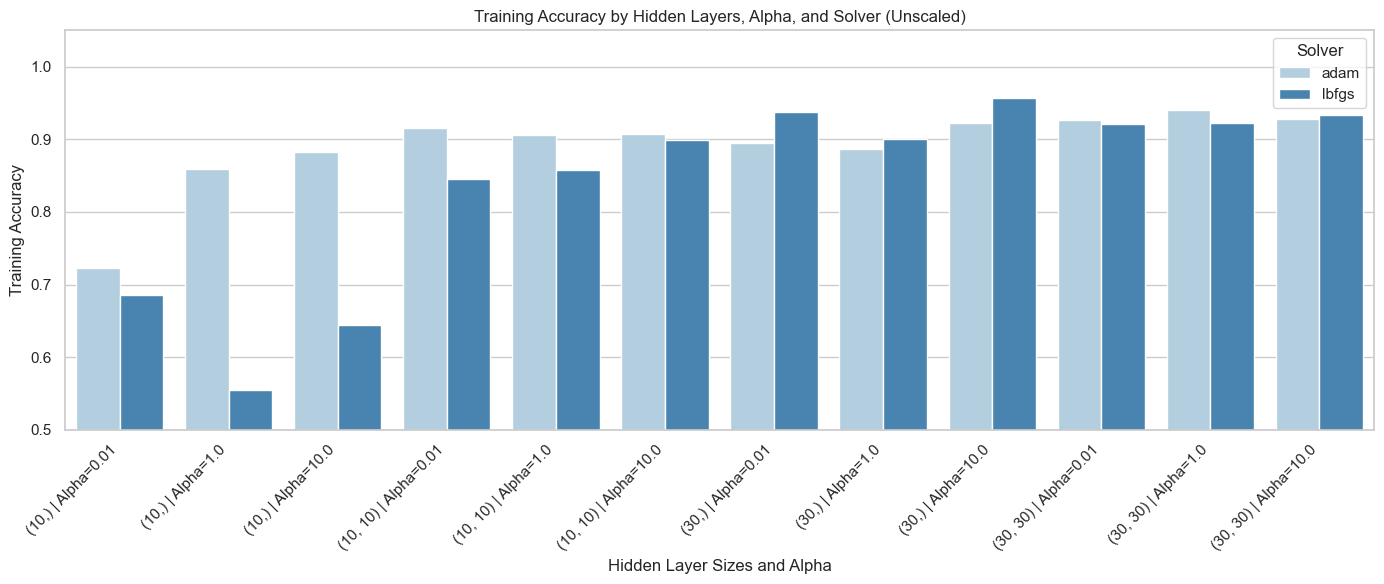

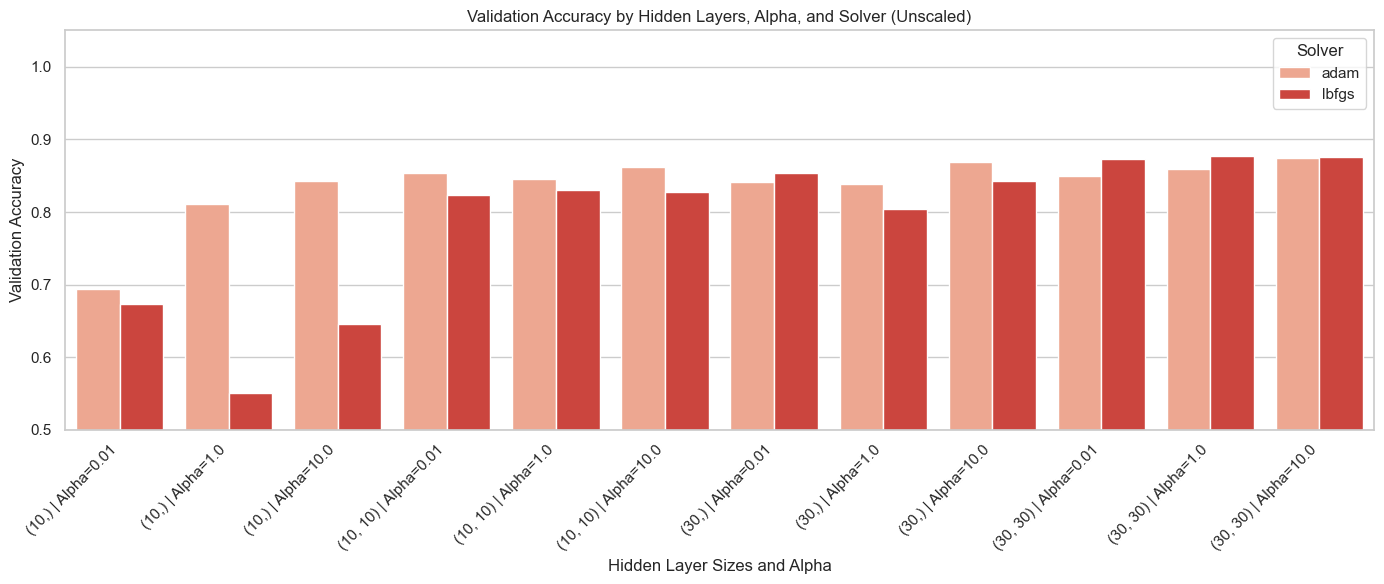

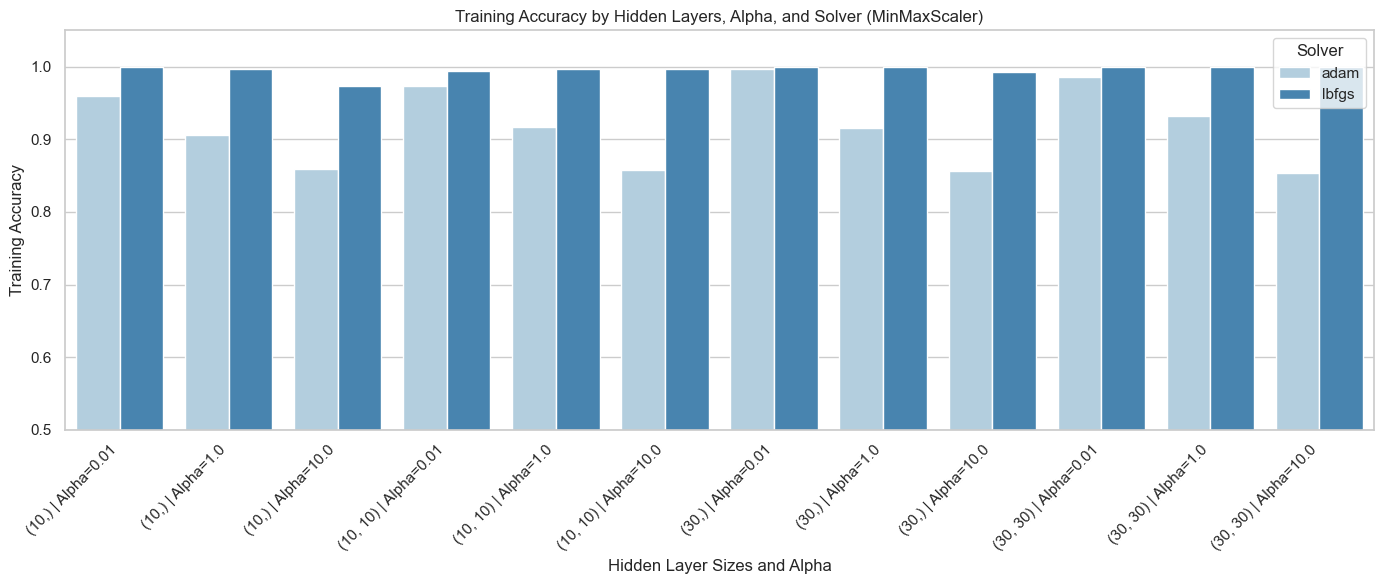

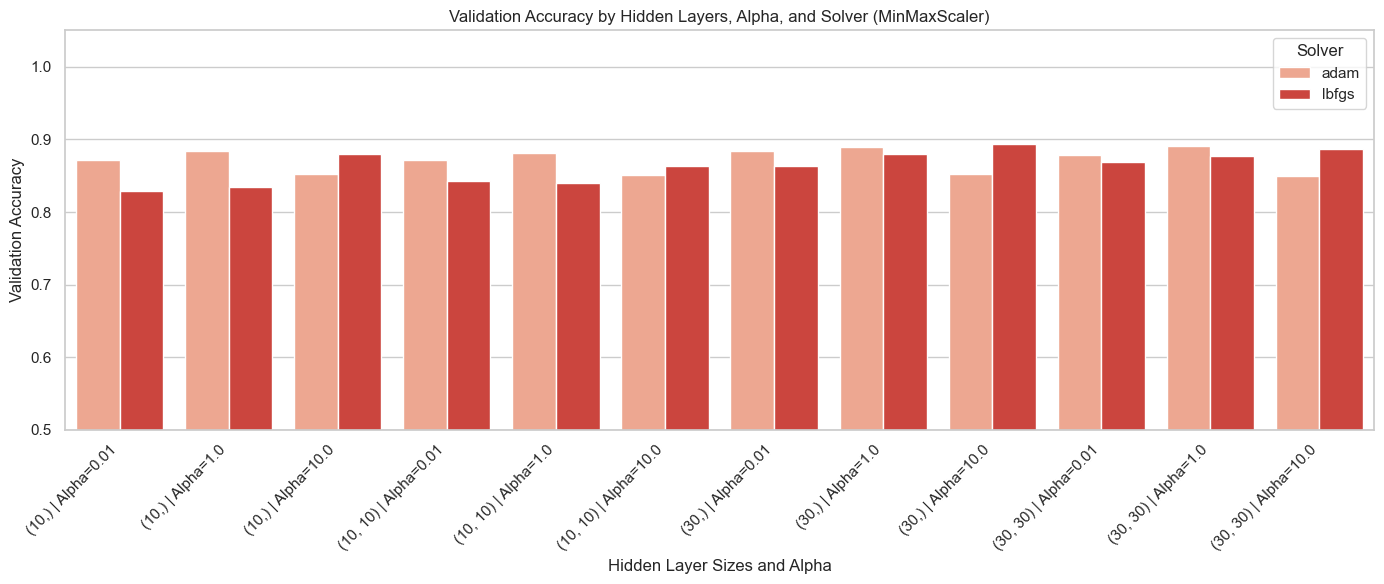

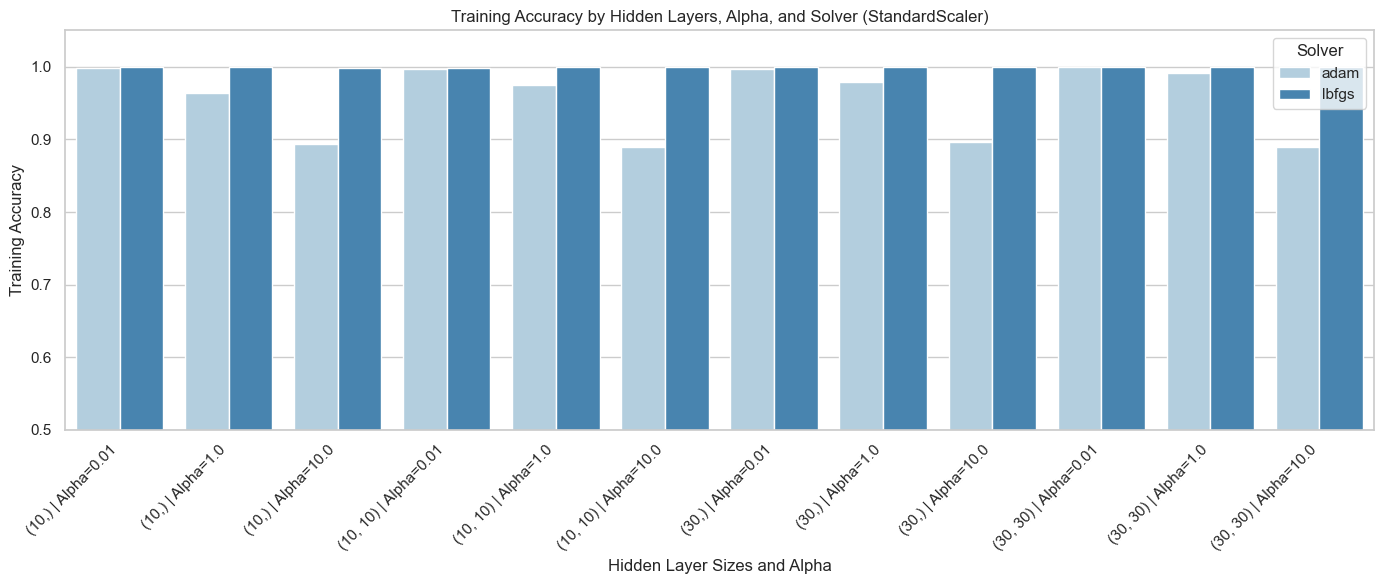

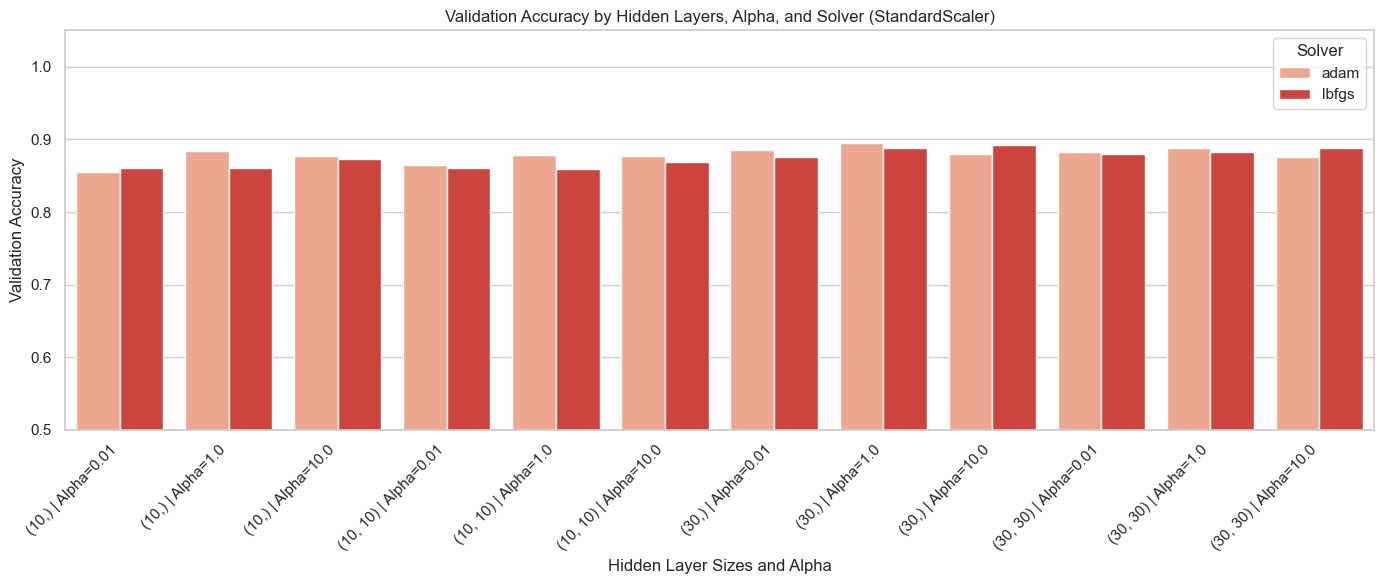

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot bar chart for training and validation accuracy separately
def plot_mlp_bar_chart_separate(results_df, scaler_name):
    sns.set(style="whitegrid")
    
    # Bar chart for Training Accuracy
    plt.figure(figsize=(14, 6))
    
    # Create a new column combining hidden_layer_sizes and alpha for x-axis labels
    results_df['layer_alpha'] = results_df['hidden_layer_sizes'].astype(str) + " | Alpha=" + results_df['alpha'].astype(str)
    
    # Training Accuracy bar plot
    sns.barplot(data=results_df, x='layer_alpha', y='avg_train_accuracy', hue='solver', errorbar=None, palette='Blues')
    plt.title(f'Training Accuracy by Hidden Layers, Alpha, and Solver ({scaler_name})')
    plt.xlabel('Hidden Layer Sizes and Alpha')
    plt.ylabel('Training Accuracy')
    plt.ylim(0.5, 1.05)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Solver')
    plt.tight_layout()
    plt.show()

    # Validation Accuracy bar plot
    plt.figure(figsize=(14, 6))
    sns.barplot(data=results_df, x='layer_alpha', y='avg_val_accuracy', hue='solver', errorbar=None, palette='Reds')
    plt.title(f'Validation Accuracy by Hidden Layers, Alpha, and Solver ({scaler_name})')
    plt.xlabel('Hidden Layer Sizes and Alpha')
    plt.ylabel('Validation Accuracy')
    plt.ylim(0.5, 1.05)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Solver')
    plt.tight_layout()
    plt.show()

# Assuming you have the dataframes for each scaling method:
# unscaled_df, minmax_df, standard_df

# Plot for Unscaled
plot_mlp_bar_chart_separate(unscaled_df, 'Unscaled')

# Plot for MinMaxScaler
plot_mlp_bar_chart_separate(minmax_df, 'MinMaxScaler')

# Plot for StandardScaler
plot_mlp_bar_chart_separate(standard_df, 'StandardScaler')


In [33]:

X_train_array = X_train.values
X_test_array = X_test.values


scaler = MinMaxScaler()


X_train_scaled = scaler.fit_transform(X_train_array)
X_test_scaled = scaler.transform(X_test_array)

In [34]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 30), alpha=1.0, solver='adam', max_iter=2000, random_state=42)


start_time = time.time()
mlp.fit(X_train_scaled, y_train)
train_time = time.time() - start_time


train_accuracy = accuracy_score(y_train, mlp.predict(X_train_scaled))


start_time = time.time()
y_test_pred = mlp.predict(X_test_scaled)
test_time = time.time() - start_time


test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"MLP Model - Training Accuracy: {train_accuracy:.4f}")
print(f"MLP Model - Testing Accuracy: {test_accuracy:.4f}")
print(f"MLP Model - Training Time: {train_time:.4f} seconds")
print(f"MLP Model - Testing Time: {test_time:.4f} seconds")


MLP Model - Training Accuracy: 0.9317
MLP Model - Testing Accuracy: 0.8858
MLP Model - Training Time: 20.1245 seconds
MLP Model - Testing Time: 0.0137 seconds


In [35]:
svm_poly = SVC(kernel='poly', C=1.0, gamma=0.01, random_state=42)


start_time = time.time()
svm_poly.fit(X_train_scaled, y_train)
train_time = time.time() - start_time


train_accuracy = accuracy_score(y_train, svm_poly.predict(X_train_scaled))


start_time = time.time()
y_test_pred = svm_poly.predict(X_test_scaled)
test_time = time.time() - start_time


test_accuracy = accuracy_score(y_test, y_test_pred)


print(f"SVM Model - Training Accuracy: {train_accuracy:.4f}")
print(f"SVM Model - Testing Accuracy: {test_accuracy:.4f}")
print(f"SVM Model - Training Time: {train_time:.4f} seconds")
print(f"SVM Model - Testing Time: {test_time:.4f} seconds")

SVM Model - Training Accuracy: 0.9257
SVM Model - Testing Accuracy: 0.8762
SVM Model - Training Time: 10.8434 seconds
SVM Model - Testing Time: 6.4680 seconds


In [36]:
train_accuracy_mlp = 0.9317  
test_accuracy_mlp = 0.8858   
train_time_mlp = 20.1245      
test_time_mlp = 0.0137       

train_accuracy_svm = 0.9257 
test_accuracy_svm = 0.8762   
train_time_svm = 10.8434     
test_time_svm = 6.4680

In [37]:
results = {
    'Model': ['MLP', 'SVM'],
    'Training Accuracy': [train_accuracy_mlp, train_accuracy_svm],
    'Testing Accuracy': [test_accuracy_mlp, test_accuracy_svm],
    'Training Time (s)': [train_time_mlp, train_time_svm],
    'Testing Time (s)': [test_time_mlp, test_time_svm]
}


results_df = pd.DataFrame(results)

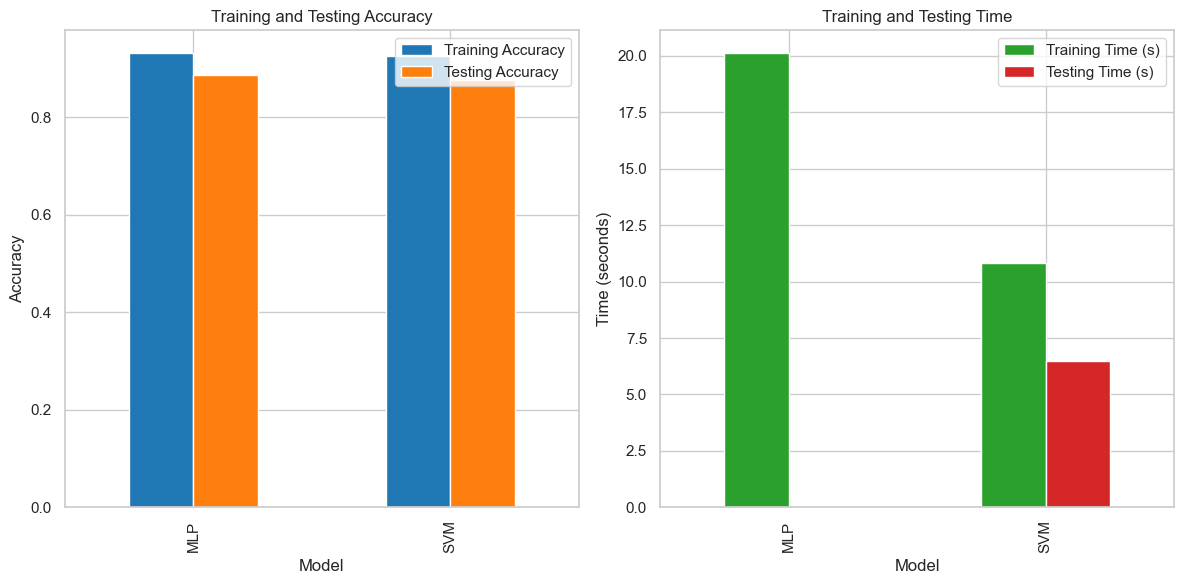

In [40]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)  
results_df.plot(kind='bar', x='Model', y=['Training Accuracy', 'Testing Accuracy'], ax=plt.gca(), color=['#1f77b4', '#ff7f0e'])
plt.title('Training and Testing Accuracy')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)  
results_df.plot(kind='bar', x='Model', y=['Training Time (s)', 'Testing Time (s)'], ax=plt.gca(), color=['#2ca02c', '#d62728'])
plt.title('Training and Testing Time')
plt.ylabel('Time (seconds)')


plt.tight_layout()
plt.show()

In [44]:
svm_poly = SVC(kernel='poly', C=1, gamma=0.01, probability=True)
mlp = MLPClassifier(hidden_layer_sizes=(30, 30), alpha=1.0, solver='adam', max_iter=2000, random_state=42)

mlp.fit(X_train_scaled, y_train)
svm_poly.fit(X_train_scaled, y_train)

svm_proba = svm_poly.predict_proba(X_test_scaled)  # Use svm_poly here
mlp_proba = mlp.predict_proba(X_test_scaled)

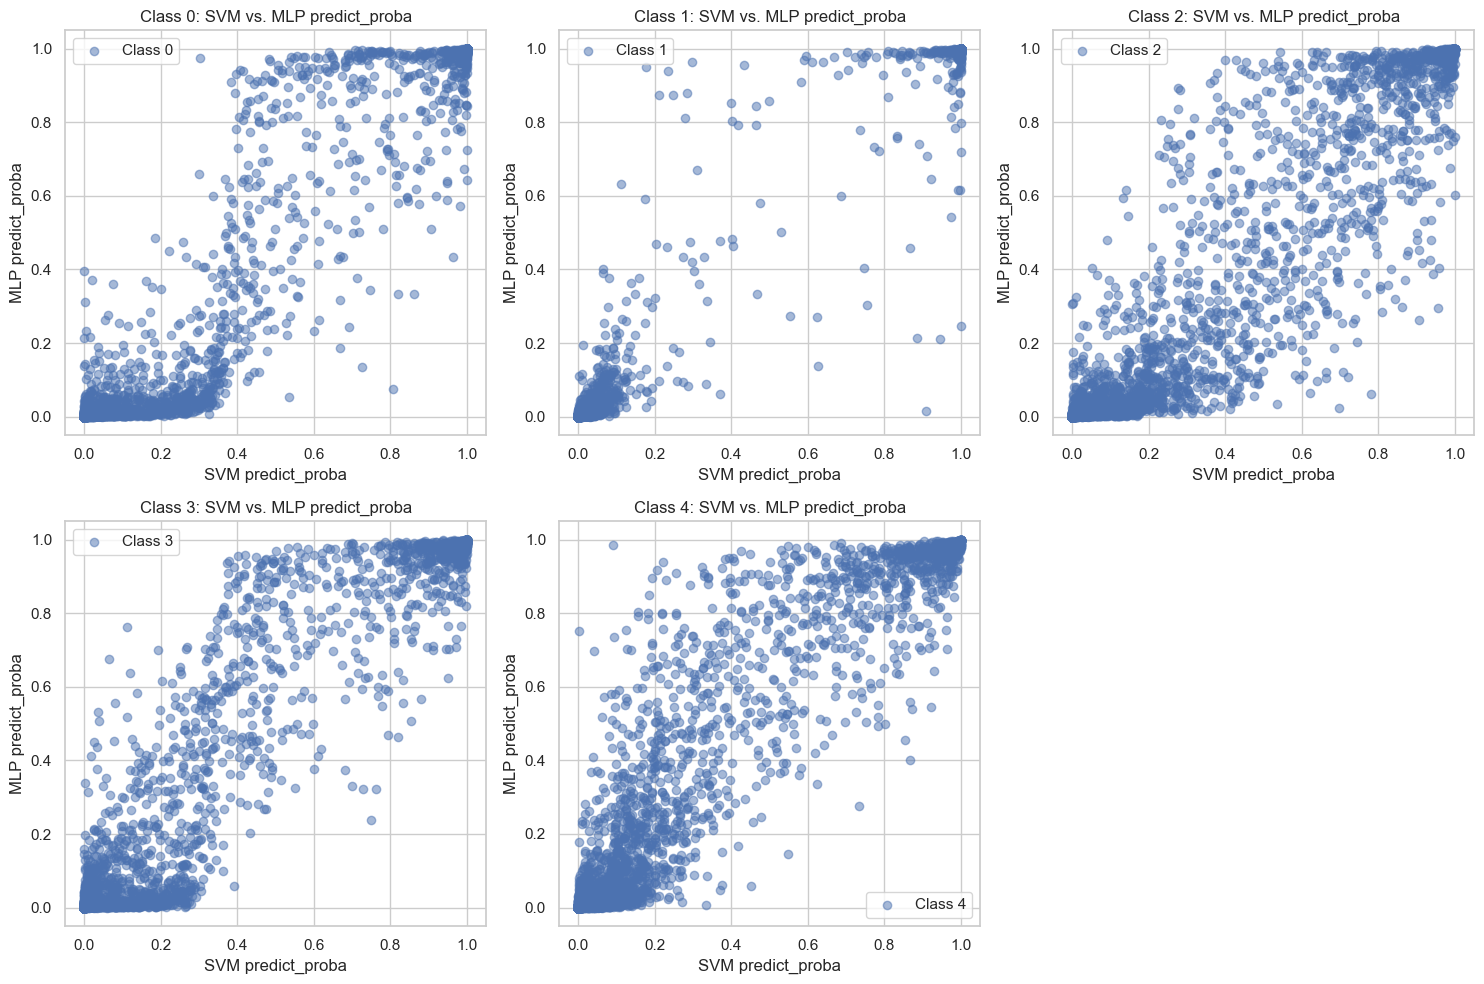

In [45]:
n_classes = 5


plt.figure(figsize=(15, 10))
for i in range(n_classes):
    plt.subplot(2, 3, i+1)  
    plt.scatter(svm_proba[:, i], mlp_proba[:, i], alpha=0.5, label=f'Class {i}')
    plt.xlabel('SVM predict_proba')
    plt.ylabel('MLP predict_proba')
    plt.title(f'Class {i}: SVM vs. MLP predict_proba')
    plt.legend()

plt.tight_layout()
plt.show()

In [49]:
threshold = 0.8


G1 = (svm_proba > threshold) & (mlp_proba < 1 - threshold)


G2 = (mlp_proba > threshold) & (svm_proba < 1 - threshold)


G3 = (svm_proba < 1 - threshold) & (mlp_proba < 1 - threshold)

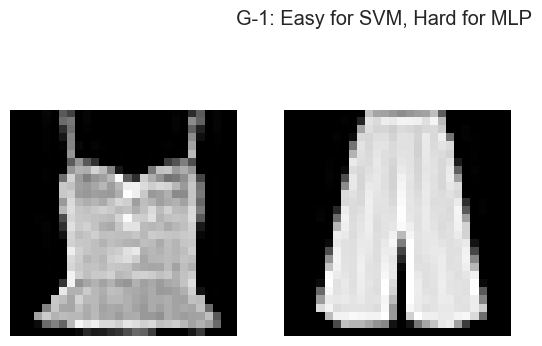

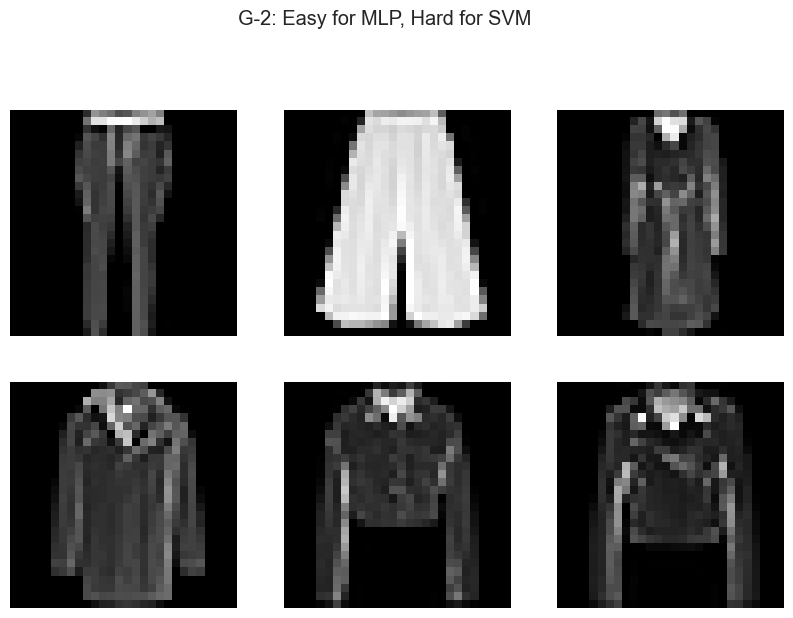

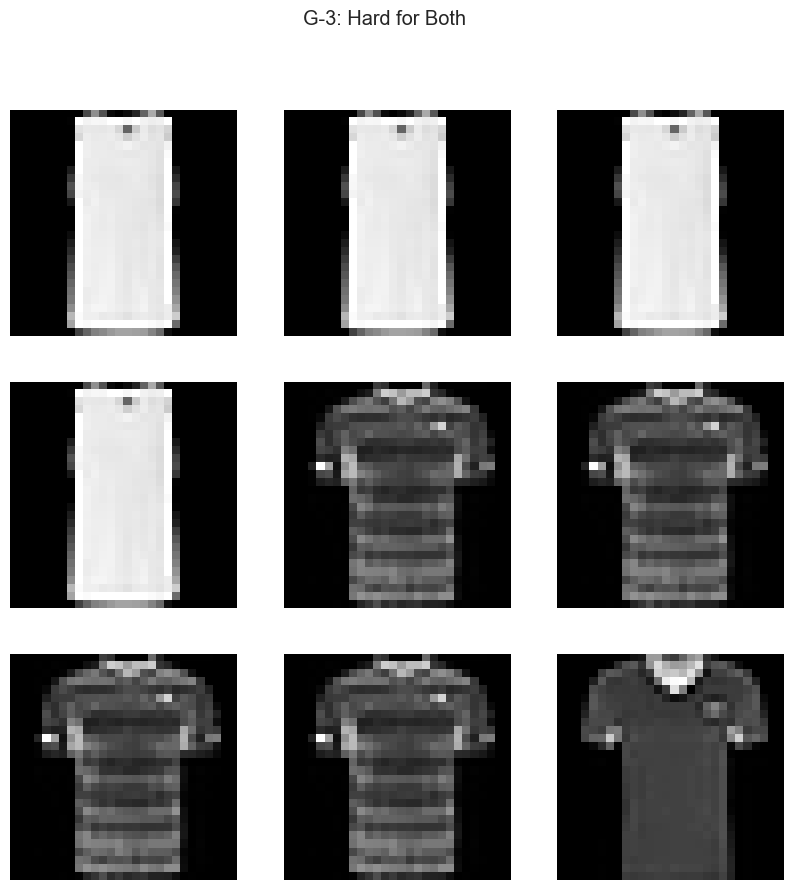

In [50]:
def display_images(X, indices, title):
 
    valid_indices = [i for i in indices if i < len(X)]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(valid_indices[:9]):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


display_images(X_test_scaled, G1_indices, "G-1: Easy for SVM, Hard for MLP")
display_images(X_test_scaled, G2_indices, "G-2: Easy for MLP, Hard for SVM")
display_images(X_test_scaled, G3_indices, "G-3: Hard for Both")
